## Implementation Code of the paper and proposed methodology as will

### Name: Muhammad Waqas
### Roll No: 25i-7649
### Section: MAI

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

# Torch + Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTForImageClassification

# Augmentation
import albumentations as A

# Stats
import scipy.stats as sstats

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle


c:\Users\mwaqa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub.file_download").setLevel(logging.ERROR)



#### USER CONFIG 

In [3]:
# ---------- USER CONFIG ----------
DATA_DIR = r"D:\Courses\MS (AI)\Courses\Deep Learning\Research\Base paper\XAI-Med-Images-Stat-Visual-Rules-main\My Code\Brain Tumor MRI Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VIT_MODEL = "google/vit-base-patch16-224-in21k"
TOP_K = 12

CLASS_NAMES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print("Classes:", CLASS_NAMES)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


#### Dataset loader

In [4]:
# ---------------- Dataset loader ----------------
class MRIImageFolder(Dataset):
    def __init__(self, paths, labels, feature_extractor, augment=False):
        self.paths = paths
        self.labels = labels
        self.fe = feature_extractor
        self.augment = augment
        self.train_aug = A.Compose([
            A.Resize(224, 224),
            A.Rotate(limit=15, p=0.5),
            A.OneOf([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)], p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = np.array(Image.open(p).convert('RGB'))
        if self.augment:
            img = self.train_aug(image=img)['image']
        enc = self.fe(images=img, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        item['path'] = p
        return item
    
    

#### Build file lists

In [5]:
# ---------------- Build file lists ----------------
def build_file_list(dirpath):
    paths, labels = [], []
    for i, cls in enumerate(CLASS_NAMES):
        cls_dir = os.path.join(dirpath, cls)
        if not os.path.isdir(cls_dir):
            continue
        for f in glob.glob(os.path.join(cls_dir, "*")):
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                paths.append(f)
                labels.append(i)
    return paths, labels

train_paths, train_labels = build_file_list(TRAIN_DIR)
test_paths, test_labels   = build_file_list(TEST_DIR)
print("Train images:", len(train_paths), "Test images:", len(test_paths))

# merge and split
all_paths = train_paths + test_paths
all_labels = train_labels + test_labels
train_p, val_p, train_y, val_y = train_test_split(all_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42)


Train images: 5712 Test images: 1311


#### ViT fine-tuning

In [6]:
# ---------------- ViT fine-tuning ----------------
fe = ViTImageProcessor.from_pretrained(VIT_MODEL)
vit_model = ViTForImageClassification.from_pretrained(
    VIT_MODEL,
    num_labels = len(CLASS_NAMES)
).to(DEVICE)

for param in vit_model.vit.encoder.layer[:-4]:  # freeze all but last 4 layers
    param.requires_grad = False

train_ds = MRIImageFolder(train_p, train_y, fe, augment=True)
val_ds   = MRIImageFolder(val_p, val_y, fe, augment=False)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


#### Extract embeddings

In [7]:
# ---------- Extract embeddings ----------
def extract_vit_embeddings(dataloader, model):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            pixel_values = batch['pixel_values'].to(DEVICE)

            # forward pass
            outputs = model(pixel_values, output_hidden_states=True)

            # take CLS token from last hidden layer
            cls_emb = outputs.hidden_states[-1][:, 0, :].cpu().numpy()

            embeddings.append(cls_emb)
            labels.extend(batch['label'].cpu().numpy())

    return np.vstack(embeddings), np.array(labels)


print("Extracting embeddings...")
X_train_emb, y_train_arr = extract_vit_embeddings(train_dl, vit_model)
X_val_emb, y_val_arr     = extract_vit_embeddings(val_dl, vit_model)


Extracting embeddings...


100%|██████████| 132/132 [07:54<00:00,  3.60s/it]


In [37]:
print(X_train_emb.shape, y_train_arr.shape)

(4916, 768) (4916,)


#### Compute statistical features from trainable embeddings

In [8]:
# ---------- Compute 26 statistical features from trainable embeddings ----------
def compute_26_stats(vec):
    x = np.array(vec).astype(float)
    n = len(x)
    s = {}
    
    # Central tendency
    s['mean'] = np.mean(x)
    s['median'] = np.median(x)
    
    # Dispersion
    s['std'] = np.std(x)
    s['variance'] = np.var(x)
    s['rms'] = np.sqrt(np.mean(x**2))
    
    # Min/Max/Range
    s['min'] = np.min(x)
    s['max'] = np.max(x)
    s['range'] = s['max'] - s['min']
    
    # Shape of distribution
    s['skew'] = sstats.skew(x)
    s['kurtosis'] = sstats.kurtosis(x)
    
    # Entropy / information
    x_shifted = np.abs(x) + 1e-12  # avoid zeros
    s['entropy'] = float(sstats.entropy(x_shifted))
    s['shannon_entropy'] = float(sstats.entropy(x_shifted, base=2))
    
    # Robust statistics
    s['mad'] = np.mean(np.abs(x - s['mean']))
    s['medad'] = np.median(np.abs(x - s['median']))
    s['iqr'] = np.percentile(x, 75) - np.percentile(x, 25)
    s['p25'] = np.percentile(x, 25)
    s['p50'] = np.percentile(x, 50)
    s['p75'] = np.percentile(x, 75)
    
    # Signal quality
    s['snr'] = 0.0 if s['std']==0 else s['mean']/s['std']  # signal-to-noise ratio
    s['cv'] = 0.0 if s['mean']==0 else s['std']/s['mean']  # coefficient of variation
    s['sem'] = 0.0 if n==0 else s['std']/math.sqrt(n)     # standard error of mean
    
    # Autocorrelation
    if n < 2:
        s['lag1_autocorr'] = 0.0
    else:
        s['lag1_autocorr'] = float(np.corrcoef(x[:-1], x[1:])[0,1]) if np.std(x[:-1])>0 and np.std(x[1:])>0 else 0.0
    
    # Percent zeros
    s['count_zero_pct'] = float((x==0).sum()/n)
    
    # Geometric mean / harmonic mean
    x_pos = np.where(x <= 0, 1e-8, x)
    try:
        s['gmean'] = float(sstats.gmean(x_pos))
    except:
        s['gmean'] = 0.0
    try:
        s['hmean'] = float(len(x)/np.sum(1.0/x_pos))
    except:
        s['hmean'] = 0.0
    
    return list(s.values())  # 26 features

In [9]:
# def compute_8_stats(vec):
#     x = np.array(vec).astype(float)
#     s = {}
#     s['mean'] = x.mean(); s['std'] = x.std()
#     s['min'] = x.min(); s['max'] = x.max()
#     s['skew'] = sstats.skew(x); s['kurtosis'] = sstats.kurtosis(x)
#     s['entropy'] = float(sstats.entropy(np.abs(x)+1e-12))
#     s['rms'] = np.sqrt(np.mean(x**2))
#     return list(s.values())  # simplified to 7 features for efficiency


In [10]:
X_train_stats = np.array([compute_26_stats(e) for e in X_train_emb])
X_val_stats   = np.array([compute_26_stats(e) for e in X_val_emb])


#### Concatenate Embeddings + Stats

In [11]:
X_train_full = np.hstack([X_train_emb, X_train_stats])
X_val_full   = np.hstack([X_val_emb, X_val_stats])


#### Standardization

In [12]:
# ---------- Standardization ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_val_scaled   = scaler.transform(X_val_full)


#### ZFMIS Feature Selection

In [13]:
from sklearn.feature_selection import mutual_info_classif

def zfmis_feature_selection(X, y, zero_thresh=0.95, top_k=None):
    """
    X: Feature matrix (samples x features)
    y: Labels
    zero_thresh: Remove features that are mostly zeros
    top_k: Select top K features by mutual information
    """
    # 1. Zero-based Filtering (remove features with > zero_thresh zeros)
    non_zero_mask = (np.count_nonzero(X, axis=0) / X.shape[0]) > (1 - zero_thresh)
    X_filtered = X[:, non_zero_mask]
    print(f"ZFMIS: {X.shape[1]} -> {X_filtered.shape[1]} features after zero-based filtering")

    # 2. Mutual Information Selection
    mi_scores = mutual_info_classif(X_filtered, y)
    if top_k is not None and top_k < len(mi_scores):
        top_idx = np.argsort(mi_scores)[-top_k:]
        X_selected = X_filtered[:, top_idx]
    else:
        X_selected = X_filtered
    
    return X_selected, non_zero_mask, mi_scores


In [14]:
# Apply ZFMIS
X_train_sel, nz_mask, mi_scores = zfmis_feature_selection(X_train_scaled, y_train_arr, zero_thresh=0.95, top_k=200)

# Apply the **same feature selection** to validation set
X_val_sel = X_val_scaled[:, nz_mask]  # apply zero-threshold mask first
X_val_sel = X_val_sel[:, :X_train_sel.shape[1]]  # keep only top 200 features to match training

ZFMIS: 793 -> 792 features after zero-based filtering


#### SMOTE for class balancing

In [15]:
# ---------- SMOTE for class balancing ----------
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_sel, y_train_arr)


In [16]:
from collections import Counter

print("Before SMOTE:", Counter(y_train_arr))
print("After SMOTE:", Counter(y_train_bal))


Before SMOTE: Counter({np.int64(2): 1400, np.int64(3): 1230, np.int64(1): 1151, np.int64(0): 1135})
After SMOTE: Counter({np.int64(0): 1400, np.int64(3): 1400, np.int64(2): 1400, np.int64(1): 1400})


In [36]:
print(len(X_train_bal[0]))
print(X_train_bal.shape)

200
(5600, 200)


# Use Neural Network

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import numpy as np

# Convert numpy → torch tensors
X_train_t = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_t = torch.tensor(y_train_bal, dtype=torch.long)

X_test_t = torch.tensor(X_val_sel, dtype=torch.float32)
y_test_t = torch.tensor(y_val_arr, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ------------------------------------------------------
# Residual Block (for tabular NN)
# ------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x

        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)

        out += identity     # <-- SKIP CONNECTION
        out = self.relu(out)

        return out

# ------------------------------------------------------
# Strong Tabular Neural Network (Best for embeddings)
# ------------------------------------------------------
class StrongTabularNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        hidden = 256

        self.fc_in = nn.Linear(input_dim, hidden)
        self.bn_in = nn.BatchNorm1d(hidden)

        self.res1 = ResidualBlock(hidden)
        self.res2 = ResidualBlock(hidden)
        self.res3 = ResidualBlock(hidden)

        self.fc_out = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.bn_in(x)
        x = torch.relu(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        return self.fc_out(x)

# Initialize model
input_dim = X_train_t.shape[1]
num_classes = len(np.unique(y_train_bal))

model = StrongTabularNN(input_dim, num_classes)

# ------------------------------------------------------
# Loss & Optimizer
# ------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007)

# ------------------------------------------------------
# Training Loop
# ------------------------------------------------------
epochs = 60
model.train()

for epoch in range(epochs):
    for batch_X, batch_y in train_loader:

        optimizer.zero_grad()
        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# ------------------------------------------------------
# Evaluation
# ------------------------------------------------------
model.eval()
with torch.no_grad():
    preds = model(X_test_t)
    predicted_classes = torch.argmax(preds, dim=1).numpy()

acc = accuracy_score(y_test_t, predicted_classes)
print("\n🔥 PyTorch Residual NN Accuracy:", acc)


Epoch [5/60], Loss: 0.0737
Epoch [10/60], Loss: 0.1992
Epoch [15/60], Loss: 0.0150
Epoch [20/60], Loss: 0.0086
Epoch [25/60], Loss: 0.0249
Epoch [30/60], Loss: 0.0485
Epoch [35/60], Loss: 0.0303
Epoch [40/60], Loss: 0.0020
Epoch [45/60], Loss: 0.0011
Epoch [50/60], Loss: 0.0978
Epoch [55/60], Loss: 0.0083
Epoch [60/60], Loss: 0.0794

🔥 PyTorch Residual NN Accuracy: 0.2752728998576175


# Use ML Models


#### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier, export_text
from rulefit import RuleFit  # pip install rulefit

# ------------------ Decision Tree ------------------
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_bal, y_train_bal)




,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
# Predict and evaluate
y_val_pred_dt = dt_model.predict(X_val_sel)
print("Decision Tree Accuracy:", accuracy_score(y_val_arr, y_val_pred_dt))
print("Classification Report (DT):\n", classification_report(y_val_arr, y_val_pred_dt))




Decision Tree Accuracy: 0.18984337921214997
Classification Report (DT):
               precision    recall  f1-score   support

           0       0.22      0.16      0.19       486
           1       0.23      0.49      0.31       494
           2       0.14      0.07      0.09       600
           3       0.10      0.08      0.09       527

    accuracy                           0.19      2107
   macro avg       0.17      0.20      0.17      2107
weighted avg       0.17      0.19      0.16      2107



In [19]:
# Extract human-readable rules
dt_rules = export_text(dt_model, feature_names=[f"f{i}" for i in range(X_train_sel.shape[1])])
print("Decision Tree Rules:\n", dt_rules)


Decision Tree Rules:
 |--- f196 <= 0.77
|   |--- f162 <= -0.38
|   |   |--- f46 <= 0.60
|   |   |   |--- f181 <= 0.45
|   |   |   |   |--- f34 <= -0.06
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- f34 >  -0.06
|   |   |   |   |   |--- class: 3
|   |   |   |--- f181 >  0.45
|   |   |   |   |--- f70 <= 0.67
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- f70 >  0.67
|   |   |   |   |   |--- class: 0
|   |   |--- f46 >  0.60
|   |   |   |--- f160 <= -0.48
|   |   |   |   |--- f184 <= 0.53
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- f184 >  0.53
|   |   |   |   |   |--- class: 2
|   |   |   |--- f160 >  -0.48
|   |   |   |   |--- f84 <= -0.05
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- f84 >  -0.05
|   |   |   |   |   |--- class: 3
|   |--- f162 >  -0.38
|   |   |--- f134 <= -0.11
|   |   |   |--- f186 <= -0.43
|   |   |   |   |--- f181 <= -0.29
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- f181 >  -0.29
|   |   |   |   |   |--- class: 1
|   

#### RuleFit

In [20]:
from rulefit import RuleFit

rf_model = RuleFit(
    tree_size=4,
    sample_fract='default',
    max_rules=2000,
    memory_par=0.01,
    rfmode='classify',      # use 'classify' instead of 'regress' for classification
    random_state=42,
    max_iter=1000           # explicitly set max_iter
)
feature_names = [f"cls{i}" for i in range(X_train_emb.shape[1])] + [f"stat{i}" for i in range(X_train_stats.shape[1])]

rf_model.fit(X_train_bal, y_train_bal, feature_names)


TypeError: RuleFit.__init__() got an unexpected keyword argument 'max_iter'

In [ ]:
# Predict and evaluate
y_val_pred_rf = rf_model.predict(X_val_sel)
y_val_pred_rf_class = (y_val_pred_rf > 0.5).astype(int)  # convert to class labels if regression mode
print("RuleFit Accuracy:", accuracy_score(y_val_arr, y_val_pred_rf_class))


RuleFit Accuracy: 0.22828666350261034


In [ ]:
# Extract top rules
rules_df = rf_model.get_rules()
rules_df = rules_df[rules_df.coef != 0].sort_values(by="support", ascending=False)
print("Top RuleFit Rules:\n", rules_df.head(10))

AttributeError: 'RuleFit' object has no attribute 'get_rules'

#### Mapping Features to Meaning

### integrate combined explainability

##### Extract ViT Attention Maps

In [21]:
import torch.nn.functional as F

def get_vit_attention_map(model, dataloader, device=DEVICE, head='mean'):
    """
    Extract attention maps from the last ViT layer.
    head: 'mean' => average over all attention heads
          int => select specific attention head
    """
    model.eval()
    att_maps = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            pixel_values = batch['pixel_values'].to(device)
            outputs = model(pixel_values, output_attentions=True, return_dict=True)

            # take attentions from last layer
            attn = outputs.attentions[-1]  # (batch_size, n_heads, num_tokens, num_tokens)

            if head == 'mean':
                attn_map = attn.mean(dim=1)  # mean over heads
            else:
                attn_map = attn[:, head, :, :]

            # CLS token attention to all patches
            cls_attn = attn_map[:, 0, 1:]  # ignore CLS-to-CLS
            att_maps.append(cls_attn.cpu().numpy())

    return np.vstack(att_maps)


##### Overlay Attention on Original Image

In [22]:
def visualize_attention(image_path, att_map, patch_size=16):
    """
    Overlay attention map on original image
    """
    img = np.array(Image.open(image_path).convert('RGB'))
    h, w, _ = img.shape

    # reshape attention to approximate image size
    n_patches = int(np.sqrt(att_map.shape[0]))
    att_map_resized = att_map.reshape(n_patches, n_patches)
    att_map_resized = np.kron(att_map_resized, np.ones((patch_size, patch_size)))

    att_map_resized = att_map_resized[:h, :w]  # crop to original image
    att_map_resized = (att_map_resized - att_map_resized.min()) / (att_map_resized.max() - att_map_resized.min())

    # overlay
    plt.imshow(img)
    plt.imshow(att_map_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


  0%|          | 0/132 [00:00<?, ?it/s]

100%|██████████| 132/132 [19:45<00:00,  8.98s/it]


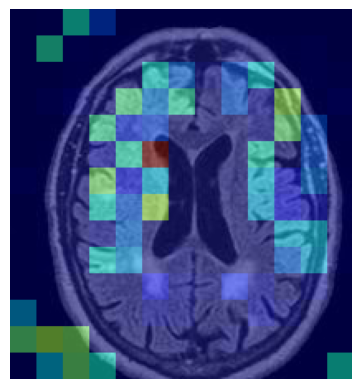

In [23]:
att_maps_val = get_vit_attention_map(vit_model, val_dl)
visualize_attention(val_ds[0]['path'], att_maps_val[0])


In [24]:
# Create feature names for the selected features
all_feature_names = [f"cls{i}" for i in range(X_train_emb.shape[1])] + \
                    [f"stat{i}" for i in range(X_train_stats.shape[1])]

# nz_mask comes from ZFMIS zero-threshold filtering
selected_feature_names = np.array(all_feature_names)[nz_mask]  # first filtering step

# If MI top_k selection was applied, further filter
if X_train_sel.shape[1] < len(selected_feature_names):
    top_idx = np.argsort(mi_scores)[-X_train_sel.shape[1]:]
    selected_feature_names = selected_feature_names[top_idx]

# Now pass the correct number of feature names to export_text
rules = export_text(dt_model, feature_names=selected_feature_names)
print("\nDecision Tree Explanation:\n", rules)



Decision Tree Explanation:
 |--- cls576 <= 0.77
|   |--- cls138 <= -0.38
|   |   |--- cls509 <= 0.60
|   |   |   |--- cls548 <= 0.45
|   |   |   |   |--- cls230 <= -0.06
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cls230 >  -0.06
|   |   |   |   |   |--- class: 3
|   |   |   |--- cls548 >  0.45
|   |   |   |   |--- cls198 <= 0.67
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cls198 >  0.67
|   |   |   |   |   |--- class: 0
|   |   |--- cls509 >  0.60
|   |   |   |--- cls581 <= -0.48
|   |   |   |   |--- cls27 <= 0.53
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cls27 >  0.53
|   |   |   |   |   |--- class: 2
|   |   |   |--- cls581 >  -0.48
|   |   |   |   |--- cls281 <= -0.05
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- cls281 >  -0.05
|   |   |   |   |   |--- class: 3
|   |--- cls138 >  -0.38
|   |   |--- cls659 <= -0.11
|   |   |   |--- cls635 <= -0.43
|   |   |   |   |--- cls548 <= -0.29
|   |   |   |   |   |--- class: 2
|   |   |   |   |---

##### Combine with Rule-Based Explanation

In [25]:
def hybrid_explanation(idx, att_maps, rule_model, feature_names=None):
    """
    Combine attention + rules
    """
    print(f"Image: {val_ds[idx]['path']}")

    # Attention map
    visualize_attention(val_ds[idx]['path'], att_maps[idx])

    # Rule-based explanation (Decision Tree example)
    node_indicator = dt_model.decision_path(X_val_sel[idx].reshape(1, -1))
    leave_id = dt_model.apply(X_val_sel[idx].reshape(1, -1))
    rules = export_text(dt_model, feature_names=feature_names)
    print("\nDecision Tree Explanation:\n", rules)


Image: D:\Courses\MS (AI)\Courses\Deep Learning\Research\Base paper\XAI-Med-Images-Stat-Visual-Rules-main\My Code\Brain Tumor MRI Dataset\Training\notumor\Tr-no_0643.jpg


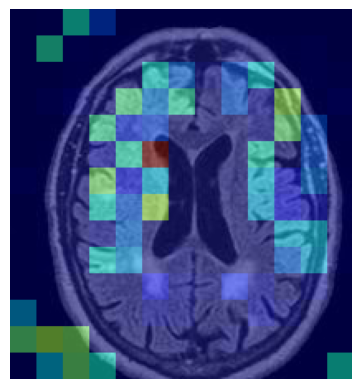


Decision Tree Explanation:
 |--- cls576 <= 0.77
|   |--- cls138 <= -0.38
|   |   |--- cls509 <= 0.60
|   |   |   |--- cls548 <= 0.45
|   |   |   |   |--- cls230 <= -0.06
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cls230 >  -0.06
|   |   |   |   |   |--- class: 3
|   |   |   |--- cls548 >  0.45
|   |   |   |   |--- cls198 <= 0.67
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cls198 >  0.67
|   |   |   |   |   |--- class: 0
|   |   |--- cls509 >  0.60
|   |   |   |--- cls581 <= -0.48
|   |   |   |   |--- cls27 <= 0.53
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cls27 >  0.53
|   |   |   |   |   |--- class: 2
|   |   |   |--- cls581 >  -0.48
|   |   |   |   |--- cls281 <= -0.05
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- cls281 >  -0.05
|   |   |   |   |   |--- class: 3
|   |--- cls138 >  -0.38
|   |   |--- cls659 <= -0.11
|   |   |   |--- cls635 <= -0.43
|   |   |   |   |--- cls548 <= -0.29
|   |   |   |   |   |--- class: 2
|   |   |   |   |---

In [26]:
# feature_names = [f"cls{i}" for i in range(X_train_emb.shape[1])] + [f"stat{i}" for i in range(X_train_stats.shape[1])]
hybrid_explanation(0, att_maps_val, dt_model, feature_names=selected_feature_names)


#### Evaluation

##### 1. Quantitative Metrics

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, X, y, model_type='dt'):
    """
    Evaluate Decision Tree / RuleFit predictions on validation set
    """
    if model_type in ['dt', 'rulefit']:
        y_pred = model.predict(X)
    else:
        raise ValueError("Unsupported model_type")

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)

    # If binary classification, compute AUC
    auc = None
    if len(np.unique(y)) == 2:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X)[:, 1]
            auc = roc_auc_score(y, y_prob)

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc}")
    return acc, prec, rec, f1, auc


In [28]:
# Decision Tree
evaluate_model(dt_model, X_val_sel, y_val_arr, model_type='dt')
# For RuleFit
evaluate_model(rf_model, X_val_sel, y_val_arr, model_type='rulefit')


Accuracy: 0.1898, Precision: 0.1686, Recall: 0.1898, F1: 0.1638, AUC: None


NameError: name 'rf_model' is not defined

##### 2. Explainability Metrics

In [ ]:
def compute_iou(att_map, gt_mask, threshold=0.5):
    """
    Compute Intersection-over-Union between attention and ground-truth mask
    """
    att_bin = (att_map > threshold).astype(np.uint8)
    intersection = np.logical_and(att_bin, gt_mask).sum()
    union = np.logical_or(att_bin, gt_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

def rule_fidelity(rule_model, vit_preds, X):
    """
    Fraction of times the rule-based model agrees with ViT predictions
    """
    rule_preds = rule_model.predict(X)
    fidelity = np.mean(rule_preds == vit_preds)
    print(f"Rule fidelity: {fidelity:.4f}")
    return fidelity


In [ ]:
# ViT predictions for validation set
vit_model.eval()
vit_preds = []
with torch.no_grad():
    for batch in val_dl:
        pixel_values = batch['pixel_values'].to(DEVICE)
        outputs = vit_model(pixel_values)
        vit_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

rule_fidelity(dt_model, np.array(vit_preds), X_val_sel)


Rule fidelity: 0.2164


np.float64(0.21642145230185098)

#### Use XGBoost instead of DT/RuleFit

In [ ]:
# this all is use in the above code  but here for the usage of the variable and also apply the stabnderdization in the code
# print("Extracting embeddings...")
# X_train_emb, y_train_arr = extract_vit_embeddings(train_dl, vit_model)
# X_val_emb, y_val_arr     = extract_vit_embeddings(val_dl, vit_model)

# # ---------- Standardization ----------
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_full)
# X_val_scaled   = scaler.transform(X_val_full)

# ---------- SMOTE for class balancing ----------
# sm = SMOTE(random_state=42)
# X_train_bal_without_FE , y_train_bal_without_FE = sm.fit_resample(X_train_emb, y_train_arr)



#### Better alternative: Class weights (MUCH more stable)

In [ ]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_full)
# X_val_scaled   = scaler.transform(X_val_full)


In [29]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight("balanced", y_train_arr)

# clf = xgb.XGBClassifier(
#     max_depth=12,
#     n_estimators=1200,
#     learning_rate=0.03,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     gamma=0.0,
#     reg_lambda=2,
#     reg_alpha=1,
#     objective='multi:prob',
#     num_class=len(CLASS_NAMES),
#     eval_metric='mlogloss'
# )

clf = xgb.XGBClassifier(
    booster='dart',              # <--- VERY IMPORTANT
    max_depth=6,
    min_child_weight=2,
    subsample=0.9,
    colsample_bytree=0.9,
    learning_rate=0.02,
    n_estimators=2500,
    gamma=0.1,
    reg_alpha=0.3,
    reg_lambda=1.2,
    sample_type='weighted',      # for dart
    normalize_type='forest',     # for dart
    rate_drop=0.15,              # dropout rate
    skip_drop=0.5,
    objective='multi:prob',
    num_class=len(CLASS_NAMES),
    eval_metric='mlogloss',
    tree_method='hist'
)

clf.fit(X_train_scaled, y_train_arr, sample_weight=sample_weights)


,objective,'multi:softprob'
,base_score,None
,booster,'dart'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [30]:
y_pred = clf.predict_proba(X_val_scaled).argmax(axis=1)
accuracy_score(y_val_arr, y_pred)

0.9197911722828667

In [ ]:
y_val_pred = clf.predict(X_val_emb)
accuracy_score(y_val_arr, y_val_pred)

In [ ]:
# ViT predictions for validation set
vit_model.eval()
vit_preds = []
with torch.no_grad():
    for batch in val_dl:
        pixel_values = batch['pixel_values'].to(DEVICE)
        outputs = vit_model(pixel_values)
        vit_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

rule_fidelity(dt_model, np.array(vit_preds), X_val_sel)


Rule fidelity: 0.2164


np.float64(0.21642145230185098)

In [ ]:
# clf = xgb.XGBClassifier(
#     max_depth=10,
#     n_estimators=500,
#     learning_rate=0.05,
#     objective='multi:softmax',
#     num_class=len(CLASS_NAMES),
#     eval_metric='mlogloss',
#     use_label_encoder=False
# )
# clf.fit(X_train_bal_without_FE, y_train_bal_without_FE)



In [ ]:
y_val_pred = clf.predict(X_val_emb)
accuracy_score(y_val_arr, y_val_pred)

0.912672045562411

In [67]:
print(X_val_sel.shape, y_val_arr.shape)


(2107, 200) (2107,)


##### 3. Qualitative Evaluation

In [ ]:
visualize_attention(val_ds[idx]['path'], att_maps_val[idx])


# Another Model

#### Train XGBoost

In [62]:
# # ---------- Train XGBoost ----------
# clf = xgb.XGBClassifier(
#     max_depth=10,
#     n_estimators=500,
#     learning_rate=0.05,
#     objective='multi:softmax',
#     num_class=len(CLASS_NAMES),
#     eval_metric='mlogloss',
#     use_label_encoder=False
# )

# clf.fit(
#     X_train_bal, y_train_bal,
#     eval_set=[(X_val_scaled, y_val_arr)],
#     # eval_metric="logloss",
#     # early_stopping_rounds=20,
#     verbose=True
# )

# this grid defines all possible combinations of these parameters (3×3×3×3×3×3×3×3 = 6561 combinations) i change it to 729 combination due to time complexity
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8],
    'learning_rate': [0.03],
    'n_estimators': [800],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'gamma': [0.2],
    'min_child_weight': [1],
    'reg_lambda': [2],
    'reg_alpha': [0.2],
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=len(CLASS_NAMES)),
    param_grid=params,
    cv=3,
    scoring='accuracy',
    verbose=2
)
grid.fit(X_train_bal, y_train_bal)
print(grid.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=800, reg_alpha=0.2, reg_lambda=2, subsample=0.9; total time=  49.3s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=800, reg_alpha=0.2, reg_lambda=2, subsample=0.9; total time=  47.3s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.03, max_depth=8, min_child_weight=1, n_estimators=800, reg_alpha=0.2, reg_lambda=2, subsample=0.9; total time=  50.9s
{'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 800, 'reg_alpha': 0.2, 'reg_lambda': 2, 'subsample': 0.9}


#### Evaluate

In [64]:
# ---------- Evaluate ----------
# y_pred = clf.predict(X_val_scaled)
y_pred = grid.predict(X_val_sel)
print("XGBoost val accuracy:", accuracy_score(y_val_arr, y_pred))
print(classification_report(y_val_arr, y_pred, target_names=CLASS_NAMES))


XGBoost val accuracy: 0.2615092548647366
              precision    recall  f1-score   support

      glioma       0.24      0.23      0.24       486
  meningioma       0.27      0.57      0.37       494
     notumor       0.25      0.20      0.23       600
   pituitary       0.26      0.06      0.10       527

    accuracy                           0.26      2107
   macro avg       0.26      0.27      0.23      2107
weighted avg       0.26      0.26      0.23      2107



#### Print and Save Best Parameters

In [26]:
# =====================================================
# Print and Save Best Parameters
# =====================================================
print("Best Parameters Found:")
print(grid.best_params_)

with open("best_xgb_params.txt", "w") as f:
    f.write("Best Parameters:\n")
    for key, value in grid.best_params_.items():
        f.write(f"{key}: {value}\n")

Best Parameters Found:
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 800}


#### Get the Best Model

In [27]:
# =====================================================
# Get the Best Model
# =====================================================

best_xgb = grid.best_estimator_


#### Save the Best Model

In [28]:
# =====================================================
# Save the Best Model
# =====================================================
pickle.dump({'xgb': grid, 'scaler': scaler}, open("xgb_vit_brain_tumor.pkl", "wb"))
print("Best model saved as 'best_xgb_model.pkl'")

Best model saved as 'best_xgb_model.pkl'


#### Extract and Save Human-Readable Rules

In [29]:
# =====================================================
# Extract and Save Human-Readable Rules
# =====================================================
booster = best_xgb.get_booster()
rules_text = booster.get_dump(with_stats=True)

with open("xgboost_rules.txt", "w") as f:
    for i, tree in enumerate(rules_text):
        f.write(f"\n================ Tree {i} ================\n")
        f.write(tree)

print("Human-readable XGBoost rules saved to 'xgboost_rules.txt'")


Human-readable XGBoost rules saved to 'xgboost_rules.txt'


#### RULEFIT FOR EXPLAINABILITY

In [ ]:
# ============================================================
#                  RULEFIT FOR EXPLAINABILITY
# ============================================================
from imodels import RuleFit

# RuleFit works on tabular input, so we use scaled + balanced data
print("\nTraining RuleFit model for explainable rules...")
rf = RuleFit(
    tree_generator=xgb.XGBClassifier(
        **grid.best_params_,
        objective='binary:logistic' if len(CLASS_NAMES) == 2 else 'multi:softprob',
        num_class=len(CLASS_NAMES),
        random_state=42
    ),
    max_rules=1000,
    random_state=42
)
rf.fit(X_train_bal, y_train_bal, feature_names=[f"f{i}" for i in range(X_train_bal.shape[1])])

# Get rules and coefficients
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
print("\nTop RuleFit Rules:\n", rules.head(20))
rules.to_csv("rulefit_rules.csv", index=False)
print("RuleFit rules saved to rulefit_rules.csv")

# Predict using RuleFit
y_pred_rf = rf.predict(X_val_scaled)
if len(CLASS_NAMES) == 2:
    y_pred_rf = (np.array(y_pred_rf) >= 0.5).astype(int)
else:
    y_pred_rf = np.round(y_pred_rf).astype(int)

print("RuleFit Validation Accuracy (approx):", accuracy_score(y_val_arr, y_pred_rf))
print(classification_report(y_val_arr, y_pred_rf, target_names=CLASS_NAMES))

# Save both models together
pickle.dump({'xgb': best_xgb, 'rulefit': rf, 'scaler': scaler}, open("xgb_rulefit_vit_brain_tumor.pkl", "wb"))
print("XGBoost + RuleFit models saved as xgb_rulefit_vit_brain_tumor.pkl")

#### VISUALIZATION HELPERS

In [ ]:
# ============================================================
#                VISUALIZATION HELPERS (UPDATED)
# ============================================================

import matplotlib.cm as cm
from skimage.transform import resize as imresize
import seaborn as sns

# ---------- Helper: entropy ----------
def entropy_of_vector(vec):
    x = np.abs(vec) + 1e-12
    p = x / np.sum(x)
    return float(-np.sum(p * np.log2(p)))

# ---------- Helper: aggregate attentions ----------
def aggregate_attentions(attentions):
    """
    Aggregate last 4 attention layers and average across heads.
    """
    last_layers = attentions[-4:] if len(attentions) >= 4 else attentions
    agg = None
    for layer in last_layers:
        mean_head = layer.mean(axis=0)
        agg = mean_head if agg is None else agg + mean_head
    agg /= len(last_layers)
    cls_attn = agg[0, 1:]  # attention from CLS token to patches
    return cls_attn

# ---------- Helper: convert attention to heatmap ----------
def attention_to_heatmap(attn_vec, image_size=(224,224), patch_size=16):
    pcount = int(math.sqrt(len(attn_vec)))
    heat = attn_vec.reshape(pcount, pcount)
    heat_norm = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    heat_up = imresize(heat_norm, image_size, preserve_range=True)
    return heat_up

# ---------- Helper: overlay heatmap ----------
def overlay_heatmap_on_image(img_path, heatmap, alpha=0.5, cmap="jet", outpath=None):
    img = np.array(Image.open(img_path).convert("RGB").resize(heatmap.shape))
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(heatmap, cmap=cmap, alpha=alpha)
    plt.axis("off")
    if outpath:
        plt.savefig(outpath, bbox_inches='tight', dpi=150)
        plt.close()
    else:
        plt.show()

# ---------- Compute SFMOV (Statistical Feature Map of Vision) ----------
def compute_sfmov_for_sample(img_path, vit_model, fe, patch_size=16):
    img = Image.open(img_path).convert("RGB")
    enc = fe(images=img, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(enc['pixel_values'].to(DEVICE), output_attentions=False, output_hidden_states=True)
        last_hidden = outputs.last_hidden_state[0].cpu().numpy()  # (seq, dim)

    # Ignore CLS token
    patch_embs = last_hidden[1:]
    means = np.array([p.mean() for p in patch_embs])
    skews = np.array([sstats.skew(p) for p in patch_embs])
    ents  = np.array([entropy_of_vector(p) for p in patch_embs])

    pcount = int(math.sqrt(means.shape[0]))

    def norm_and_reshape(arr):
        a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
        return imresize(a.reshape(pcount, pcount), (img.size[1], img.size[0]), preserve_range=True)

    mean_map = norm_and_reshape(means)
    skew_map = norm_and_reshape(skews)
    ent_map = norm_and_reshape(ents)

    # Combine maps with weights from CLS embedding
    if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
        cls_vec = outputs.pooler_output.cpu().numpy()[0]
    else:
        cls_vec = outputs.last_hidden_state[:,0,:].cpu().numpy()[0]
    w_mean = float(np.mean(cls_vec))
    w_skew = float(sstats.skew(cls_vec))
    w_ent = entropy_of_vector(cls_vec)

    ws = np.array([w_mean, w_skew, w_ent])
    ws = (ws - ws.min()) / (ws.max() - ws.min() + 1e-8)
    combined = ws[0]*mean_map + ws[1]*skew_map + ws[2]*ent_map
    combined = (combined - combined.min()) / (combined.max() - combined.min() + 1e-8)

    return mean_map, skew_map, ent_map, combined

# ---------- Visualize attention + statistical maps ----------
print("\nGenerating attention and SFMOV visualizations...")
os.makedirs("viz", exist_ok=True)

# Sample a few images from validation set
sample_images = val_p[:8]  # using your val paths
for img_path in sample_images:
    # Step 1: Compute attentions
    inputs = fe(images=Image.open(img_path).convert('RGB'), return_tensors="pt")
    with torch.no_grad():
        out = vit_model.vit(inputs['pixel_values'].to(DEVICE), output_attentions=True)
        attentions = [a.cpu().numpy() for a in out.attentions]

    attn_vec = aggregate_attentions(attentions)
    heat = attention_to_heatmap(attn_vec, image_size=(224,224))
    overlay_heatmap_on_image(img_path, heat, alpha=0.5, outpath=f"viz/attn_{os.path.basename(img_path)}.png")

    # Step 2: Compute SFMOV
    mean_map, skew_map, ent_map, comb = compute_sfmov_for_sample(img_path, vit_model, fe)
    overlay_heatmap_on_image(img_path, comb, alpha=0.5, cmap='viridis', outpath=f"viz/sfmov_{os.path.basename(img_path)}.png")

    # Step 3: Fused visualization (Attention × Statistical Map)
    fused = (heat * comb)
    fused = (fused - fused.min()) / (fused.max() - fused.min() + 1e-8)
    overlay_heatmap_on_image(img_path, fused, alpha=0.6, cmap='jet', outpath=f"viz/fused_{os.path.basename(img_path)}.png")

print("\nVisualization complete — saved in 'viz/' folder.")
print("Models saved as xgb_rulefit_vit_brain_tumor.pkl and rulefit_rules.csv")
